## Imports

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random
import unicodedata
import string
import torch
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from torch import nn, optim
from SearchClassifier.word_classifier.data_loader import random_training_example, split_dataset
from SearchClassifier.word_classifier.mutiLayerRNN import MultilayerRnn
from SearchClassifier.word_classifier.predict import evaluate, predict
from SearchClassifier.word_classifier.rnn import RNN
from SearchClassifier.word_classifier.test import test_with_plot
from SearchClassifier.word_classifier.train import train, train_loop
from SearchClassifier.word_classifier.utils import unicode_to_ascii, letter_to_tensor, line_to_tensor, n_letters, \
    category_from_output, load_checkpoint, save_checkpoint

## Global variables
Change for running configuration

In [2]:
TRAINING_PERCENT = 70
TEST_PERCENT = 20
VIEW_PERCENT = 10
LEARNING_RATE = 0.005  # If you set this too high, it might explode. If too low, it might not learn
EPOCHS = 5000
PRINT_EVERY = 100
PLOT_EVERY = 100
N_HIDDEN = 128
EXEC_MODE = 2
PATH = "models/model.pt"
PATH2 = "models/model2.pt"

### Configuration
Data loading and environment configuration

In [3]:
def find_files(path): return glob.glob(path)


print(find_files('data/products/*.txt'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []


# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]


for filename in find_files('data/products/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

training_dataset, test_dataset, view_dataset = split_dataset(category_lines, TRAINING_PERCENT, TEST_PERCENT, VIEW_PERCENT)

line_to_tensor('Jose Ramón').size()

['data/products/toys.txt', 'data/products/music.txt', 'data/products/book.txt', 'data/products/smartphone.txt', 'data/products/clothes.txt', 'data/products/food.txt', 'data/products/games.txt', 'data/products/fitness.txt']


torch.Size([10, 1, 57])

## Creating RNN

In [4]:
if EXEC_MODE == 1:
    rnn = RNN(n_letters, N_HIDDEN, n_categories)
elif EXEC_MODE == 2:
    rnn = RNN(n_letters, N_HIDDEN, n_categories)
    rnn2 = MultilayerRnn(n_letters, N_HIDDEN, n_categories)
else:
    print("Loading network")
    rnn = RNN(n_letters, N_HIDDEN, n_categories)
    rnn = load_checkpoint(rnn, PATH)
    #rnn.eval()
inputChar = letter_to_tensor('A')

hidden = torch.zeros(1, N_HIDDEN)

rnn

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=8, bias=True)
  (softmax): LogSoftmax()
)

### Getting output

In [5]:
output, next_hidden = rnn(inputChar, hidden)
category_from_output(all_categories, output)

('music', 1)

### Showing samples

In [6]:
for i in range(10):
    category, line, category_tensor, line_tensor = random_training_example(all_categories, training_dataset)
    print('category =', category, '/ line =', line)

category = music / line = Californication
category = music / line = Rolling Papers
category = smartphone / line = Samsung Galaxy Note Edge
category = smartphone / line = Meizu MX
category = food / line = Bombones Lindor Cornet Blanco Lindt
category = smartphone / line = Samsung Galaxy S Zoom
category = clothes / line = NIKE M NP Short Pantalones Cortos de Deporte, Hombre
category = toys / line = Djeco Juegos de accion y reflejosJuegos educativosDJECOJuego Mosquito, Multicolor 
category = smartphone / line = OnePlus 
category = toys / line = Tranjis Games  Virus  Juego de cartas TRGvir


### Defining criterion
NLLLoss() is good because the last layer of the RNN is nn.LogSoftmax I have to see the different criterion and activation functions

In [7]:
if EXEC_MODE == 1 or EXEC_MODE == 2:
    criterion = nn.NLLLoss()

## Training
each loop of training
  1) Create input and target tensors
  2) Create zeroed initial hidden state
  3) Read each letter in and keep hidden state for next letter
  4) Compare final output to target
  5) Back-propagate
  6) Return to output and loss
Keep track of losses for plotting

In [8]:
if EXEC_MODE == 1:
    print("Training network")
    rnn, all_losses = train_loop(rnn, criterion, all_categories, training_dataset, EPOCHS, LEARNING_RATE, PRINT_EVERY, PLOT_EVERY)
if EXEC_MODE == 2:
    print("Training first network")
    rnn, all_losses = train_loop(rnn, criterion, all_categories, training_dataset, EPOCHS, LEARNING_RATE, PRINT_EVERY, PLOT_EVERY)
    print("Training second network")
    rnn2, all_losses2 = train_loop(rnn2, criterion, all_categories, training_dataset, EPOCHS, LEARNING_RATE, PRINT_EVERY, PLOT_EVERY)

Training first network
100 2% (0m 0s) 2.0814 Moto Z Play / book ✗ (smartphone)
200 4% (0m 1s) 2.0880 NIKE Jordan Clc Snapback Gorra, Unisex Adulto / book ✗ (clothes)
300 6% (0m 2s) 2.0522 AGE OF MYTHOLOGY GOLD EDITION / fitness ✗ (games)
400 8% (0m 3s) 2.0156 Djeco Juegos de accion y reflejosJuegos educativosDJECOJuego Mosquito, Multicolor  / clothes ✗ (toys)
500 10% (0m 4s) 2.0415 Knorr Sopa China de Sichuan   g / games ✗ (food)
600 12% (0m 5s) 1.9970 Lindt Lindor Tableta de Chocolate Blanco,  g / food ✓
700 14% (0m 6s) 2.0916 Joma Nobel Pantalon de equipacion / games ✗ (clothes)
800 16% (0m 7s) 1.8061 Velocity Exercise Gray Magnetic Upright Exercise Bike / fitness ✓
900 18% (0m 8s) 1.9133 Whatever People Say I Am That's What I Am Not Vinilo / music ✓
1000 20% (0m 9s) 2.0336 Catch / music ✗ (book)
1100 22% (0m 10s) 2.0130 Ulysses / toys ✗ (book)
1200 24% (0m 11s) 1.9133 Saint Cloud Vinilo / music ✓
1300 26% (0m 12s) 1.5397 adidas Core TR SHO Pantalones Cortos de Deporte, Hombre / clot

## Plotting info
1. One plot is a square of classes, in every square is represented the
index of times is predicted one class when it's the other
It's good to be yellow on diagonal
2. The other is de function loss progression

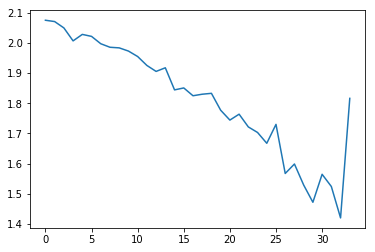

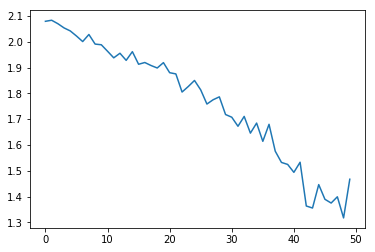

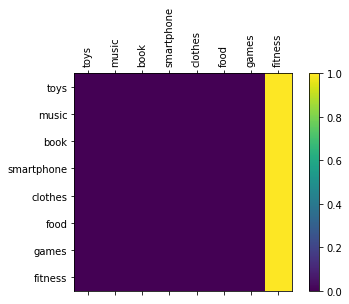

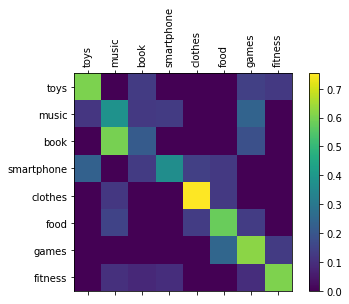

In [9]:
if EXEC_MODE == 1 or EXEC_MODE == 2:
    plt.figure()
    plt.plot(all_losses)
if EXEC_MODE == 2:
    plt.figure()
    plt.plot(all_losses2)

test_with_plot(rnn, test_dataset, all_categories)
if EXEC_MODE == 2:
    test_with_plot(rnn2, test_dataset, all_categories)

## Saving and Loading
Saving and Loading model functions

In [10]:
save_checkpoint(rnn, PATH)
if EXEC_MODE == 2:
    save_checkpoint(rnn2, PATH2)

### Some predicts

In [11]:
for key in view_dataset.keys():
    for value in view_dataset[key]:
        predict(rnn, value, all_categories, 3)


> TWISTER  Manta de Picnic, diseno de Juego Twister
(nan) book
(nan) music
(nan) fitness

> PlayDoh Bolsa De  Mini Botes Hasbro EU
(nan) book
(nan) music
(nan) fitness

> Palabrea, Juego educativo en familia de agilidad mental, Desarrollo del lenguaje Ludilo
(nan) book
(nan) music
(nan) fitness

> Death Certificate
(nan) book
(nan) music
(nan) fitness

> One More Light
(nan) book
(nan) music
(nan) fitness

> Lust For Life
(nan) book
(nan) music
(nan) fitness

> Take Care
(nan) book
(nan) music
(nan) fitness

> Wuthering Heights
(nan) book
(nan) music
(nan) fitness

> Nineteen Eighty Four
(nan) book
(nan) music
(nan) fitness

> Samsung Galaxy S
(nan) book
(nan) music
(nan) fitness

> Samsung Galaxy Grand Prime
(nan) book
(nan) music
(nan) fitness

> Nokia  PureView
(nan) book
(nan) music
(nan) fitness

> NIKE Dry Academy  Chandal, Hombre
(nan) book
(nan) music
(nan) fitness

> Joma Treviso  Pantalones Cortos Equipamiento Hombre
(nan) book
(nan) music
(nan) fitness

> Nike W Np Pro Clas